In [1]:
import numpy as np
import tensorflow as tf
import gym
import math
import matplotlib.pyplot as plt

# CartPole

---

### OpenAI Gym Environment - [CartPole-v1](https://gym.openai.com/envs/CartPole-v1/) 

"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center."

---

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


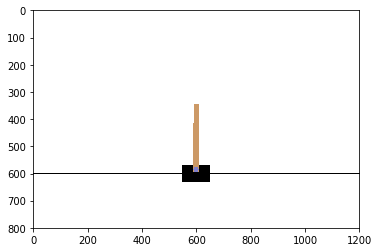

In [2]:
env = gym.make('CartPole-v1')
env.reset()
plt.imshow(env.render(mode='rgb_array'))

---

## Environment Specifications

Markov Decision Process specified by states, actions, transition probabilities, and rewards.

---

In [3]:
# States
n_states = env.observation_space.shape[0]
sample_state = env.observation_space.sample()

print("\nState represention: {0}-dimensional vector.".format(n_states))
print("\nSample state: {0}".format(sample_state))
print("\nTypes: {0}".format([type(x) for x in sample_state]))


State represention: 4-dimensional vector.

Sample state: [4.6860966e-01 1.4645028e+38 8.6090848e-02 3.0545910e+37]

Types: [<class 'numpy.float32'>, <class 'numpy.float32'>, <class 'numpy.float32'>, <class 'numpy.float32'>]


---
Index|	Observation  |	Min  |	Max
-----|-------------|-------|-------:
    0|	Cart Position	| -2.4	| 2.4
    1|	Cart Velocity	| -Inf	| Inf
    2|	Pole Angle	| -41.8°	| 41.8°
    3|	Pole Velocity At Tip	|-Inf	| Inf
    
---

In [4]:
# Actions
n_actions = env.action_space.n
sample_action = [env.action_space.sample()]

print("\nNumber of actions: {0}".format(n_actions))
print("\nSample action: {0}".format(sample_action))
print("\nTypes: {0}".format([type(x) for x in sample_action]))


Number of actions: 2

Sample action: [1]

Types: [<class 'int'>]


---
Num	| Action
----|-------:
0	| Push cart to the left
1	| Push cart to the right

---

In [6]:
# Sample sequence
env.reset()
s_hist, a_hist, r_hist = [], [], []
while True:
    a = env.action_space.sample()
    s, r, d, _ = env.step(a)

    s_hist.append(s)
    a_hist.append(a)
    r_hist.append(r)

    if d:
        break
    
print("State / Action / Reward")
list(zip(s_hist, a_hist, r_hist))

State / Action / Reward


[(array([-0.00703989,  0.22997927,  0.02051046, -0.24570378]), 1, 1.0),
 (array([-0.0024403 ,  0.42480237,  0.01559638, -0.5318473 ]), 1, 1.0),
 (array([ 0.00605574,  0.22946456,  0.00495944, -0.23429107]), 0, 1.0),
 (array([0.01064503, 0.0342721 , 0.00027361, 0.05995208]), 0, 1.0),
 (array([ 0.01133048,  0.22939013,  0.00147266, -0.2326445 ]), 1, 1.0),
 (array([ 0.01591828,  0.03424717, -0.00318023,  0.06050258]), 0, 1.0),
 (array([ 0.01660322,  0.22941457, -0.00197018, -0.23318203]), 1, 1.0),
 (array([ 0.02119151,  0.42456462, -0.00663382, -0.52648577]), 1, 1.0),
 (array([ 0.02968281,  0.61977928, -0.01716354, -0.82125165]), 1, 1.0),
 (array([ 0.04207839,  0.81513183, -0.03358857, -1.11928315]), 1, 1.0),
 (array([ 0.05838103,  1.01067795, -0.05597423, -1.42231006]), 1, 1.0),
 (array([ 0.07859459,  0.81629118, -0.08442044, -1.14763439]), 0, 1.0),
 (array([ 0.09492041,  1.01240772, -0.10737312, -1.46555171]), 1, 1.0),
 (array([ 0.11516857,  0.81875203, -0.13668416, -1.20824812]), 0, 1.

---
Let's solve this with **Q-Learning** 

$Q : S \times A \rightarrow \mathbb{R}$

Update Rule:

$Q \ (s_t \ , \ a_t) \leftarrow (1-\alpha) \cdot Q \ (s_t \ , \ a_t) + \alpha \cdot (r_t + \gamma \cdot \max_a Q \ (s_{t+1}, a))$

---
...but first...

In our gridworld example Q values were updated in a table.  Our continuous space will need some work!

---

In [7]:
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))

In [8]:
STATE_BOUNDS

[(-4.8, 4.8),
 (-3.4028235e+38, 3.4028235e+38),
 (-0.41887903, 0.41887903),
 (-3.4028235e+38, 3.4028235e+38)]

In [9]:
STATE_BOUNDS[1] = (-1.,1.)
STATE_BOUNDS[3] = (-1.,1.)

In [10]:
def discretize(obs, bounds, bincount):
    s = np.zeros_like(obs, dtype='int')
    
    for i in range(len(obs)):
        s[i] = np.digitize(obs[i], np.linspace(bounds[i][0],bounds[i][1],bincount[i]))-1
        
    return tuple(s)

In [11]:
s_buckets = (30,30,30,30)
q_table = np.zeros(s_buckets + (n_actions,))

print("Q Table shape is {}".format(q_table.shape))

Q Table shape is (30, 30, 30, 30, 2)


In [12]:
#--------------------------------
# Learning parameters
#--------------------------------
alpha = 0.5
gamma = 0.99
epsilon = 1.0
decay = 0.999

alpha_min = 0.1
epsilon_min = 0.1

In [13]:
n_episodes = 10000
reward_history = []

#--------------------------------
# Iterate through pole balancing episodes
#--------------------------------
for episode in range(n_episodes):
    
    s = env.reset()
    rsum = 0
    
    explore_rate = max(epsilon_min, epsilon*decay**episode)
    
    #--------------------------------
    # individual steps through a single episode
    #--------------------------------
    while True:
        #--------------------------------
        # Epsilon greedy policy for selecting actions
        #--------------------------------
        sd = discretize(s,STATE_BOUNDS,s_buckets)
        a =  np.argmax(q_table[sd])
        if np.random.uniform() < explore_rate:
            a = np.random.choice(range(n_actions))

        #--------------------------------
        # Take selected action
        #--------------------------------            
        sp, r, d, _ = env.step(a)
        spd = discretize(sp,STATE_BOUNDS,s_buckets)

        #--------------------------------
        # Update Q table with experience tuple
        #--------------------------------        
        if d:
            q_table[sd + (a,)] = (1-alpha)*q_table[sd + (a,)] + alpha*(r)
        else:
            q_table[sd + (a,)] = (1-alpha)*q_table[sd + (a,)] + alpha*(r + gamma*max(q_table[spd]))
        
        s = sp
        rsum += r
        if d:
            break

    reward_history.append(rsum)
    #--------------------------------
    # Print out progress indicators 
    #--------------------------------
    if episode%500==0:
        print("Episode {}: Avg Reward = {}, Exploration Rate = {:.3f}".format(episode,np.mean(reward_history[-500:]),explore_rate))

Episode 0: Avg Reward = 21.0, Exploration Rate = 1.000
Episode 500: Avg Reward = 24.48, Exploration Rate = 0.606
Episode 1000: Avg Reward = 39.252, Exploration Rate = 0.368
Episode 1500: Avg Reward = 79.734, Exploration Rate = 0.223
Episode 2000: Avg Reward = 144.626, Exploration Rate = 0.135
Episode 2500: Avg Reward = 143.538, Exploration Rate = 0.100
Episode 3000: Avg Reward = 159.922, Exploration Rate = 0.100
Episode 3500: Avg Reward = 159.912, Exploration Rate = 0.100
Episode 4000: Avg Reward = 176.256, Exploration Rate = 0.100
Episode 4500: Avg Reward = 171.032, Exploration Rate = 0.100
Episode 5000: Avg Reward = 174.832, Exploration Rate = 0.100
Episode 5500: Avg Reward = 188.786, Exploration Rate = 0.100
Episode 6000: Avg Reward = 194.77, Exploration Rate = 0.100
Episode 6500: Avg Reward = 201.704, Exploration Rate = 0.100
Episode 7000: Avg Reward = 225.95, Exploration Rate = 0.100
Episode 7500: Avg Reward = 219.664, Exploration Rate = 0.100
Episode 8000: Avg Reward = 232.048, E

In [14]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

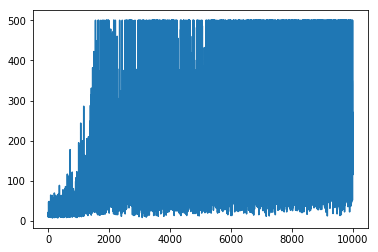

In [15]:
plt.plot(reward_history)

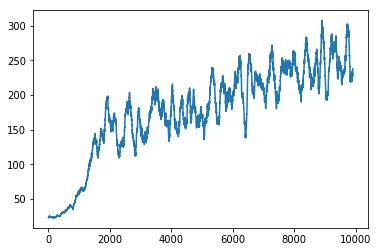

In [16]:
rmoving = running_mean(reward_history, 100)
plt.plot(rmoving)

---
## Run your trained agent for a random episode!

---

In [20]:
s = env.reset()
total_reward = 0
while True:
    sd = discretize(s,STATE_BOUNDS,s_buckets)
    a =  np.argmax(q_table[sd])

    sp, r, d, _ = env.step(a)
        
    env.render()

    total_reward += r
    s = sp
    if d:
        print(total_reward)
        break

500.0
